## Lunar Lander with PPO

The goal of this notebook is to demonstrate training Stable Baselines's algorithms (PPO)
with Gymnasium environments (Lunar Lander).

The previous notebook was simple and all self-contained.

The current notebook relies on reusable functions which are shared in `rlcourse` package and introduces various advanced techniques:
- Designing notebook such that it can use the custom library `rlcourse` when run locally and when run in environments such as Google Colab, Kaggle and others.
- Notifications of long running job completion with Telegram messages.
- Using multi-processing to speedup model training.
- Simple code for hyperparameter search: in this case it is interesting to find a set of hyperparameters that lead to quicker solution.

### Setup

First step: find course helpers library and update `sys.path` to find it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, subprocess

repo_url = "https://github.com/anton-dergunov/hugging-face-deep-rl.git"
target_dir = "hugging-face-deep-rl"
local_src = os.path.abspath("../src")

if os.path.isdir(local_src):
    repo_root = os.path.abspath("..")
    print("✅ Using local source for course helpers")
else:
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    repo_root = os.path.abspath(target_dir)
    print("✅ Cloned repo with course helpers")

src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"🔧 sys.path updated with: {src_path}")

✅ Using local source for course helpers
🔧 sys.path updated with: /Users/anton/Dropbox/src/hugging-face-deep-rl/src


In [3]:
from rlcourse.system_setup import setup_env
setup_env()

🔧 Bootstrapping environment...
✅ swig already installed
📦 Packages installed
🔇 Warnings filtered
✅ Environment ready


In [20]:
import json, random, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym

from IPython.display import Video
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import plot_results, X_TIMESTEPS
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CallbackList

from rlcourse.hf_utils import HuggingFaceModelHub
import rlcourse.gymnasium_utils as utils
from rlcourse.notifier import Notify

In [5]:
ENV_ID = "LunarLander-v3"
MODEL_NAME = "LunarLander_PPO"
REPO_ID = f"AntonDergunov/{MODEL_NAME}"

LEARN_STEPS = 1_000_000

In [6]:
LOGS_PATH_SINGLE_PROC = f"logs/{MODEL_NAME}_single_proc"
LOGS_PATH_MULTI_PROC = f"logs/{MODEL_NAME}_multi_proc"
BASE_HP_LOGS_PATH = f"logs/{MODEL_NAME}"
VIDEO_PATH = f"videos/{MODEL_NAME}.mp4"

os.makedirs(LOGS_PATH_SINGLE_PROC, exist_ok=True)
os.makedirs(LOGS_PATH_MULTI_PROC, exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)

### Environment

[Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) is a classic rocket trajectory optimization problem.

Observation Space:
1. x coordinate (horizontal position)
2. y coordinate (vertical position)
3. horizontal velocity
4. vertical velocity
5. lander angle
6. angular velocity
7. is left leg touching ground? (boolean)
8. is right leg touching ground? (boolean)

Action Space - 4 discrete actions:
- 0 = do nothing
- 1 = fire left orientation engine
- 2 = fire main engine
- 3 = fire right orientation engine

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

Episode finishes if the lander:
- crashes (gets in contact with the moon)
- gets outside of the viewpoint
- is not awake (does not move and does not collide)

"At each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points."

In [7]:
env = gym.make(ENV_ID, render_mode="rgb_array")

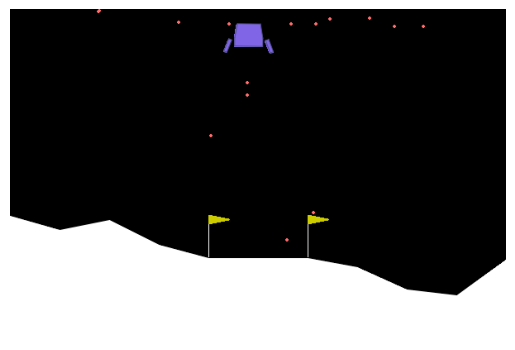

In [21]:
utils.show_environment(env)

In [9]:
utils.describe_environment(env)

Observation Space:
  Box(shape=(8,), dtype=float32, low=-10.0, high=10.0)
  Example observation: [ 1.8347118   1.6270943  -9.51167    -0.8656647   5.410437    8.686886
  0.9333294   0.08954973]

Action Space:
  Discrete(n=4)
  Example action: 2

Max episode steps: 1000


### Train PPO Model in a Single Process

In [10]:
vec_env = make_vec_env(ENV_ID, n_envs=4, monitor_dir=LOGS_PATH_SINGLE_PROC)

# Using PPO model with default hyperparameters
model_single_proc = PPO(
    policy = 'MlpPolicy',
    env = vec_env)

with Notify(f"{MODEL_NAME}: Training in a Single Process"):
    progress_cb = utils.TQDMProgressCallback(total_timesteps=LEARN_STEPS)
    model_single_proc.learn(total_timesteps=LEARN_STEPS, progress_bar=False, callback=progress_cb)

Training:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

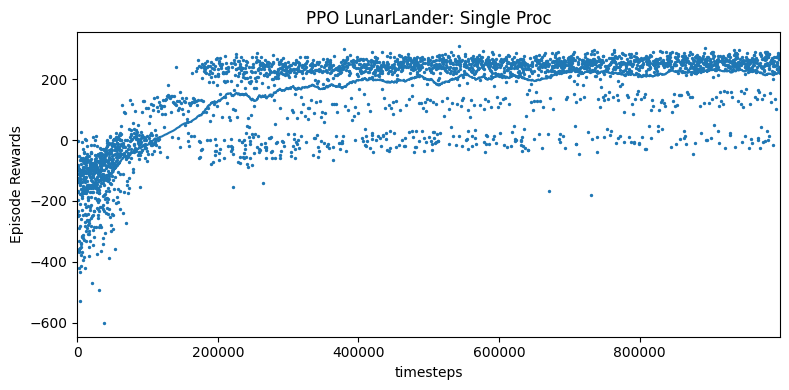

In [11]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH_SINGLE_PROC], LEARN_STEPS, X_TIMESTEPS, "PPO LunarLander: Single Proc", figsize=(8,4))
plt.show()

In [12]:
print(utils.stable_evaluate(model_single_proc, ENV_ID))

{'mean_reward': np.float64(228.89492751111115), 'std_reward': np.float64(64.06720769172448), 'ci_low': np.float64(215.65850526842783), 'ci_high': np.float64(242.13134975379447), 'n_total': 90}


### Train PPO Model with Multiprocessing

https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#multiprocessing-unleashing-the-power-of-vectorized-environments

In [13]:
# Use SubprocVecEnv for multiprocessing
num_cpu = os.cpu_count()
print(f"Using {num_cpu} subprocesses.")

subproc_vec_env = utils.make_subproc_env(ENV_ID, num_cpu, seed=0, log_dir=LOGS_PATH_MULTI_PROC)

Using 8 subprocesses.


In [14]:
# Using PPO model with default hyperparameters
model_multi_proc = PPO(
    policy = 'MlpPolicy',
    env = subproc_vec_env)

with Notify(f"{MODEL_NAME}: Training with Multiprocessing"):
    progress_cb = utils.TQDMProgressCallback(total_timesteps=LEARN_STEPS)
    model_multi_proc.learn(total_timesteps=LEARN_STEPS, progress_bar=False, callback=progress_cb)

Training:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

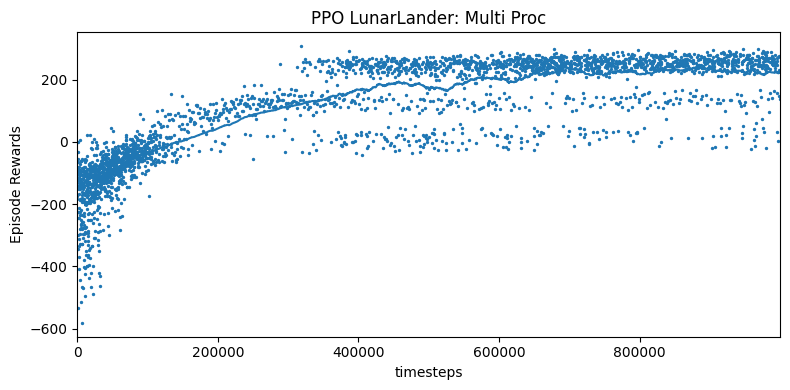

In [15]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH_MULTI_PROC], LEARN_STEPS, X_TIMESTEPS, "PPO LunarLander: Multi Proc", figsize=(8,4))
plt.show()

In [16]:
print(utils.stable_evaluate(model_multi_proc, ENV_ID))

{'mean_reward': np.float64(231.1436136444444), 'std_reward': np.float64(61.820485041494884), 'ci_low': np.float64(218.3713691103282), 'ci_high': np.float64(243.9158581785606), 'n_total': 90}


### Find Optimal Hyperparameters for PPO Model

The goal is to find hyperparameters for training PPO faster.

Documentation for eval callback: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html#stable_baselines3.common.callbacks.EvalCallback

In [17]:
def run_experiment(env_id, config, exp_name, seed=0, total_timesteps=LEARN_STEPS, threshold=200, base_dir="experiments"):
    """
    Runs one experiment.
    - config: hyper parameters of the PPO model (such as n_steps, batch_size, n_epochs, learning_rate, etc)
    - exp_name: experiment name (used to organize logs)
    - seed: RNG seed
    """
    run_dir = os.path.join(base_dir, exp_name, f"seed_{seed}")
    os.makedirs(run_dir, exist_ok=True)
    train_logdir = os.path.join(run_dir, "train")
    eval_logdir = os.path.join(run_dir, "eval")
    os.makedirs(train_logdir, exist_ok=True)
    os.makedirs(eval_logdir, exist_ok=True)

    # envs
    n_envs = os.cpu_count()
    vec_env = utils.make_subproc_env(env_id, n_proc=n_envs, seed=seed, log_dir=train_logdir)
    eval_env = utils.make_subproc_env(env_id, n_proc=1, seed=seed+1000, log_dir=eval_logdir)

    # model
    model = PPO(
        policy="MlpPolicy",
        env=vec_env,
        **config,
        verbose=0,
    )

    # eval callback
    stop_cb = StopTrainingOnRewardThreshold(reward_threshold=threshold, verbose=1)
    eval_cb = EvalCallback(
        eval_env,
        log_path=eval_logdir,
        eval_freq=10_000,
        n_eval_episodes=10,
        deterministic=True,
        callback_on_new_best=stop_cb,
        verbose=0,
    )
    progress_cb = utils.TQDMProgressCallback(total_timesteps=total_timesteps, title=exp_name)
    cb_list = CallbackList([progress_cb, eval_cb])

    # save config
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

    # train
    model.learn(total_timesteps=total_timesteps, callback=cb_list, progress_bar=False)
    model.save(os.path.join(run_dir, "final_model.zip"))

    vec_env.close()
    eval_env.close()

    return run_dir

Search space hyperparameters:

- `n_steps` - Number of steps to collect per environment before an update (rollout length). Update batch size = n_steps * n_envs. Larger n_steps → better estimate of return but larger memory + slower online updates. Common choices: 2048 (original PPO), or smaller if environment episodes are short.
- `batch_size` - Mini-batch size when doing gradient updates. SB3 will shuffle the collected rollout buffer and perform updates in batch_size slices across n_epochs passes. batch_size must be ≤ n_steps * n_envs. Typical values: 64, 128.
- `n_epochs` - Number of passes (epochs) over the collected data per update. Larger → more policy/value fitting per sampled data (more on-policy reuse), but can cause overfitting / too-large updates.
- `learning_rate`
- `gamma` - Discount factor. Very close to 1 makes algorithm long-horizon (high variance). For LunarLander (moderate episode length) γ=0.99 is a common default; 0.999 is long-horizon — OK, but expect larger variance and slower credit assignment.
- `gae_lambda` - Lambda for Generalized Advantage Estimation. Together gamma * lambda controls effective temporal smoothing of advantage estimates (a knob for bias/variance).
- `ent_coef` - Entropy coefficient multiplied by policy entropy (encourages exploration). Typical values: 0.0–0.02. If agent becomes deterministic too quickly (premature convergence), increase this. If policy remains noisy, reduce.

See other hyperparameters: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO

In [18]:
# Search space
search_space = {
    "n_steps": [1024, 2048],
    "batch_size": [64, 128],
    "n_epochs": [3, 4],
    "learning_rate": [1e-4, 3e-4, 1e-3],
    "gamma": [0.99, 0.999],
    "gae_lambda": [0.95, 0.98],
    "ent_coef": [0.0, 0.01],
}

# Minimum average reward to stop training
REWARD_THRESHOLD = 220

In [22]:
def sample_config(space):
    return {k: random.choice(v) for k, v in space.items()}

# run multiple configs sequentially (one machine)
N = 10
with Notify(f"{MODEL_NAME}: Hyperparameter Search"):
    for i in range(N):
        cfg = sample_config(search_space)
        exp_name = f"hp_run_{i}"
        print("Running", exp_name, cfg)
        run_dir = run_experiment(ENV_ID, cfg, exp_name, 100+i, LEARN_STEPS, REWARD_THRESHOLD, BASE_HP_LOGS_PATH)
        print("Finished", run_dir)

Running hp_run_0 {'n_steps': 1024, 'batch_size': 64, 'n_epochs': 3, 'learning_rate': 0.0001, 'gamma': 0.999, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_0:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_0/seed_100
Running hp_run_1 {'n_steps': 1024, 'batch_size': 64, 'n_epochs': 3, 'learning_rate': 0.0001, 'gamma': 0.999, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_1:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_1/seed_101
Running hp_run_2 {'n_steps': 2048, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.0001, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_2:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_2/seed_102
Running hp_run_3 {'n_steps': 2048, 'batch_size': 64, 'n_epochs': 4, 'learning_rate': 0.0003, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.01}


hp_run_3:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_3/seed_103
Running hp_run_4 {'n_steps': 2048, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.0001, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_4:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_4/seed_104
Running hp_run_5 {'n_steps': 2048, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.0001, 'gamma': 0.999, 'gae_lambda': 0.98, 'ent_coef': 0.0}


hp_run_5:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_5/seed_105
Running hp_run_6 {'n_steps': 1024, 'batch_size': 64, 'n_epochs': 4, 'learning_rate': 0.001, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_6:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Stopping training because the mean reward 232.30  is above the threshold 220
Finished logs/LunarLander_PPO/hp_run_6/seed_106
Running hp_run_7 {'n_steps': 2048, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.0001, 'gamma': 0.999, 'gae_lambda': 0.95, 'ent_coef': 0.0}


hp_run_7:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Finished logs/LunarLander_PPO/hp_run_7/seed_107
Running hp_run_8 {'n_steps': 1024, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.001, 'gamma': 0.99, 'gae_lambda': 0.98, 'ent_coef': 0.0}


hp_run_8:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Stopping training because the mean reward 221.57  is above the threshold 220
Finished logs/LunarLander_PPO/hp_run_8/seed_108
Running hp_run_9 {'n_steps': 1024, 'batch_size': 128, 'n_epochs': 4, 'learning_rate': 0.001, 'gamma': 0.99, 'gae_lambda': 0.98, 'ent_coef': 0.0}


hp_run_9:   0%|          | 0/1000000 [00:00<?, ?timesteps/s]

Stopping training because the mean reward 227.40  is above the threshold 220
Finished logs/LunarLander_PPO/hp_run_9/seed_109


In [23]:
def analyze_experiments(base_dir="experiments", threshold=200):
    rows = []
    for exp_dir in Path(base_dir).glob("*/"):
        for seed_dir in exp_dir.glob("seed_*"):
            run_path = str(seed_dir)
            eval_npz = os.path.join(run_path, "eval", "evaluations.npz")
            cfg_file = os.path.join(run_path, "config.json")
            if not os.path.exists(eval_npz):
                continue
            data = np.load(eval_npz, allow_pickle=True)
            timesteps = data["timesteps"]
            results = data["results"]
            # results can be shape (n_eval,) or (n_eval, n_episodes) or list-like
            if results.ndim == 2:
                mean_rewards = results.mean(axis=1)
            else:
                mean_rewards = np.array(results).astype(float)

            # time to solve
            solved_idx = np.where(mean_rewards >= threshold)[0]
            time_to_solve = int(timesteps[solved_idx[0]]) if len(solved_idx) > 0 else np.nan
            final_reward = float(mean_rewards[-1])
            # approximate AUC normalized by last timestep
            try:
                auc = float(np.trapezoid(mean_rewards, x=timesteps) / (timesteps[-1] if timesteps[-1] > 0 else 1.0))
            except Exception:
                auc = np.nan

            # load config
            try:
                with open(cfg_file) as f:
                    cfg = json.load(f)
            except Exception:
                cfg = {}

            rows.append({
                "run": exp_dir.name,
                "seed": seed_dir.name,
                "time_to_solve": time_to_solve,
                "final_reward": final_reward,
                "auc": auc,
                "config": cfg,
                "path": str(seed_dir),
            })

    df = pd.DataFrame(rows)
    # expand config columns for convenience (careful with missing keys)
    cfg_df = pd.json_normalize(df["config"])
    df2 = pd.concat([df.drop(columns=["config"]), cfg_df], axis=1)
    return df2

In [24]:
df_results = analyze_experiments(BASE_HP_LOGS_PATH, threshold=REWARD_THRESHOLD)
df_results.sort_values(["time_to_solve", "final_reward"], ascending=[True, False], inplace=True)
df_results.head(10)

,run,seed,time_to_solve,final_reward,auc,path,n_steps,batch_size,n_epochs,learning_rate,gamma,gae_lambda,ent_coef
7,hp_run_8,seed_108,320000.0,221.566411,-77.569495,logs/LunarLander_PPO/hp_run_8/seed_108,1024,128,4,0.0010,0.990,0.98,0.00
8,hp_run_6,seed_106,640000.0,232.304655,83.297253,logs/LunarLander_PPO/hp_run_6/seed_106,1024,64,4,0.0010,0.990,0.95,0.00
6,hp_run_9,seed_109,800000.0,227.400838,79.617364,logs/LunarLander_PPO/hp_run_9/seed_109,1024,128,4,0.0010,0.990,0.98,0.00
1,hp_run_3,seed_103,NaN,126.316365,-55.264127,logs/LunarLander_PPO/hp_run_3/seed_103,2048,64,4,0.0003,0.990,0.95,0.01
0,hp_run_4,seed_104,NaN,33.350397,-463.941127,logs/LunarLander_PPO/hp_run_4/seed_104,2048,128,4,0.0001,0.990,0.95,0.00
3,hp_run_5,seed_105,NaN,-47.219502,-264.951463,logs/LunarLander_PPO/hp_run_5/seed_105,2048,128,4,0.0001,0.999,0.98,0.00
2,hp_run_2,seed_102,NaN,-47.379376,-357.257975,logs/LunarLander_PPO/hp_run_2/seed_102,2048,128,4,0.0001,0.990,0.95,0.00
9,hp_run_1,seed_101,NaN,-76.348049,-215.992017,logs/LunarLander_PPO/hp_run_1/seed_101,1024,64,3,0.0001,0.999,0.95,0.00
5,hp_run_7,seed_107,NaN,-83.243079,-463.073789,logs/LunarLander_PPO/hp_run_7/seed_107,2048,128,4,0.0001,0.999,0.95,0.00
4,hp_run_0,seed_100,NaN,-121.437174,-485.350549,logs/LunarLander_PPO/hp_run_0/seed_100,1024,64,3,0.0001,0.999,0.95,0.00


### Evaluate

In [25]:
best_row = df_results.iloc[0]
print("Best run:\n")
print(best_row)

Best run:

run                                            hp_run_8
seed                                           seed_108
time_to_solve                                  320000.0
final_reward                                 221.566411
auc                                          -77.569495
path             logs/LunarLander_PPO/hp_run_8/seed_108
n_steps                                            1024
batch_size                                          128
n_epochs                                              4
learning_rate                                     0.001
gamma                                              0.99
gae_lambda                                         0.98
ent_coef                                            0.0
Name: 7, dtype: object


In [26]:
best_model_path = Path(best_row["path"]) / "final_model.zip"
best_model = PPO.load(best_model_path, device="cpu")

In [27]:
metrics = utils.stable_evaluate(best_model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(223.16825679999997), 'std_reward': np.float64(26.30241031658659), 'ci_low': np.float64(217.734122529222), 'ci_high': np.float64(228.60239107077794), 'n_total': 90}


In [28]:
utils.record_agent_video(best_model, ENV_ID, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/LunarLander_PPO.mp4


In [29]:
Video(VIDEO_PATH, embed=True)

### Hugging Face

In [30]:
hub = HuggingFaceModelHub()
hub.login_if_needed(interactive=True)

✅ Hugging Face credentials already available.


In [31]:
usage = f"""
```python
import gymnasium as gym
from stable_baselines3 import PPO
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="{REPO_ID}", filename="model.zip")
model = PPO.load(model_path, device="cpu")

env = gym.make("{ENV_ID}")
obs, info = env.reset()

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()
```
"""

hub.upload_model_file(
    repo_id=REPO_ID,
    file=best_model_path,
    filename="model.zip",
    model_name=MODEL_NAME,
    library="Stable-Baselines3",
    algo="PPO",
    env_id=ENV_ID,
    metrics=metrics,
    video_file=VIDEO_PATH,
    readme_extra=usage,
)

✅ Hugging Face credentials already available.
Uploading model.zip to AntonDergunov/LunarLander_PPO ... | size=145.71 KB | sha256=4df85eee5f350904595a9dec17ced007963102cda4f28d508e72b68d499c73cd

✅ Upload complete! View the model at:
https://huggingface.co/AntonDergunov/LunarLander_PPO


In [32]:
hub_model_file = hub.download_model_file(repo_id=REPO_ID, filename="model.zip")
model = PPO.load(hub_model_file, device="cpu")

env = gym.make(ENV_ID)
obs, info = env.reset()

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

print("✅ Model loaded from Hugging Face and tested successfully!")

Downloaded /Users/anton/.cache/huggingface/hub/models--AntonDergunov--LunarLander_PPO/snapshots/3a32de6dffcc44c07d1e02129e5f3f9433f20ccc/model.zip | size=145.71 KB | sha256=4df85eee5f350904595a9dec17ced007963102cda4f28d508e72b68d499c73cd
✅ Model loaded from Hugging Face and tested successfully!
